In [43]:
from collections import deque
from talib import SMA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Get the prices of for our assets

In [44]:
tickers = ['AAPL','MSFT','IBM','ABT','CSCO']
p = get_pricing(tickers,'2005-01-01','2017-01-05')


In [45]:
p['price'].index

DatetimeIndex(['2005-01-03', '2005-01-04', '2005-01-05', '2005-01-06',
               '2005-01-07', '2005-01-10', '2005-01-11', '2005-01-12',
               '2005-01-13', '2005-01-14',
               ...
               '2016-12-21', '2016-12-22', '2016-12-23', '2016-12-27',
               '2016-12-28', '2016-12-29', '2016-12-30', '2017-01-03',
               '2017-01-04', '2017-01-05'],
              dtype='datetime64[ns, UTC]', length=3024, freq='C')

#Implement Strategy

In [62]:
def get_result(col,a,b,p):
    idx = p['price'].columns[col]

    price = p.minor_xs(idx)['price']
    
    smaA = price.rolling(a).mean()
    
    smaB = price.rolling(b).mean()
    
    # Calculate the difference between the MA's
    sma_diff = smaA-smaB
    
    # The diff of the sign shows where the MA's cross over
    signal = np.sign(sma_diff).diff()

    # Find the index of the first signal in order to create a long-short scenario
    idx = signal[~np.isnan(signal)][signal!=0].index[0]

    # Half the first signal so we can get a switch from long to short and back every time
    signal[idx] = signal[idx]/2
    
    # Calculate the pnl by multiplying the signal wit the price
    pnl = (((price*signal).cumsum())-(price*signal.cumsum()))

    return pnl



In [63]:
get_result(0,120,100,p).ix[-1]

91.510000000000005

#Run Strategy for portfolio

In [71]:
def portfolio(a,b,tickers,p):
    
    portfolio_pnl = 0
    
    # Repeat the pnl calculation for all tickers with a specific set of parameters
    for i in range(len(tickers)):
        
        try:
            
            # Add the portfolio pnl's to get the overall pnl
            portfolio_pnl += get_result(i,a,b,p).ix[-1]
            
        except:
            
            pass
        
    return portfolio_pnl

portfolio(20,10,tickers,p)

4.4679999999999183

#Optimise Strategy parameters

(array([   1.,    1.,    4.,    6.,    9.,   10.,   15.,   25.,   28.,
          27.,   65.,   50.,   73.,   81.,  114.,  115.,  134.,  116.,
         110.,  122.,   92.,   93.,   92.,   54.,   27.,   13.,    8.,
           7.,    3.,    5.]),
 array([-122.808     , -111.22356667,  -99.63913333,  -88.0547    ,
         -76.47026667,  -64.88583333,  -53.3014    ,  -41.71696667,
         -30.13253333,  -18.5481    ,   -6.96366667,    4.62076667,
          16.2052    ,   27.78963333,   39.37406667,   50.9585    ,
          62.54293333,   74.12736667,   85.7118    ,   97.29623333,
         108.88066667,  120.4651    ,  132.04953333,  143.63396667,
         155.2184    ,  166.80283333,  178.38726667,  189.9717    ,
         201.55613333,  213.14056667,  224.725     ]),
 <a list of 30 Patch objects>)

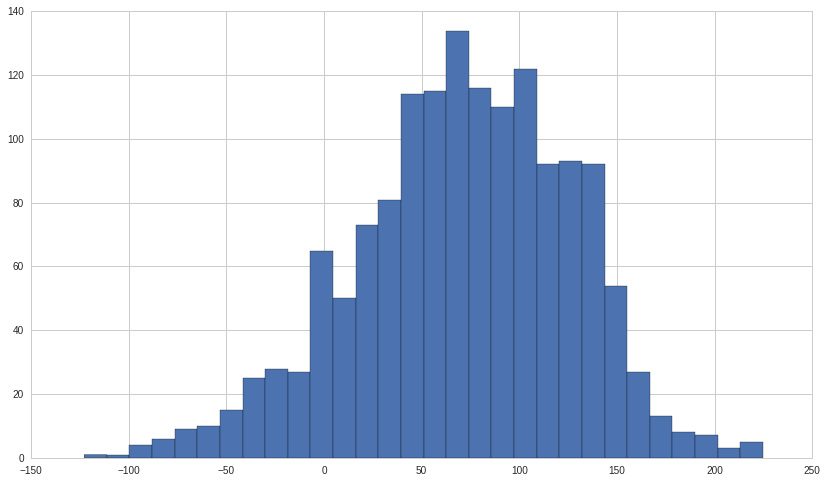

In [72]:
def optimise(tickers,p):
    # This does a randomised parameter sweep
    pnls = []
    
    for a in range(1500):

        
        # Create randomized parameters
        params = np.sort([np.random.randint(25,150),np.random.randint(5,150)])[::-1]
        
        # Add the pnls to a list
        pnls.append(portfolio(params[0],params[1],tickers,p))
        
    return pnls
            
pnls = optimise(tickers,p)

# Plot a histogram of all Pnl's
plt.hist(pnls,30)

In [73]:
np.mean(pnls)

71.233631999999986

In [74]:
np.std(pnls)

55.500632062676338

#PnL of equally weighted portfolio

In [52]:
def portfolio(a,b,tickers,p):
    # This prints the pnl curve for a strategy with specific parameters
    
    portfolio_pnls = []
    
    for i in range(len(tickers)):
        
        portfolio_pnls.append(get_result(i,a,b,p))
        
    df = pd.DataFrame(portfolio_pnls).T
    
    #df.plot()
    
    return df

df = portfolio(120,100,tickers,p)

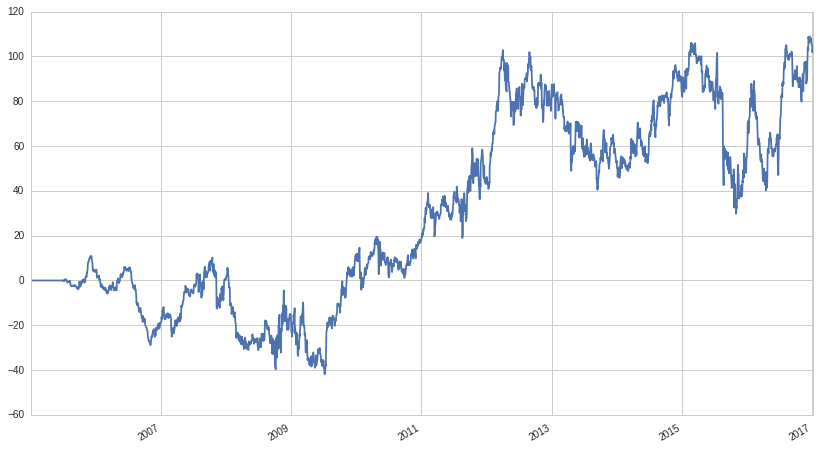

In [53]:
df.sum(axis=1).plot()